# California Housing Prices

## Summary

This dataset is a modified version of the California Housing dataset available from [Luís Torgo's page](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (University of Porto). This notebook covers the workflow for solving a data science problem including Machine Learning in a regression setting.

**Features used for Machine Learning:**

* **longitude** 
* **latitude**
* **housing_median_age**: median age (years) of a house within a block.
* **total_rooms**
* **total_bedrooms**
* **population** 
* **households**
* **median_income**: median income for households within a block of houses (measured in tens of thousands of US Dollars).
* **ocean_proximity (one hot encoding)**: indicates (roughly) whether each block group is near the ocean, near the Bay area, inland or on an island
* **rooms_per_household**
* **bedrooms_per_room** 
* **population_per_household**

**Algorithm that yields the best result (lowest RMSE):** XGBoost

* RMSE on test set = $43,231
* Mean Absolute Percentage Error on test set = 15.9%
* Symmetric Mean Absolute Percentage Error on test set = 14.5%

## Table of contents

1. [Introduction](#introduction)
2. [Required libraries](#reqlib)
3. [Problem definition](#problemdef)
4. [Basic information](#basicinfo)
5. [Exploratory Data Analysis](#eda)
    * [Create a Test Set](#createtest)
    * [Visualizing Geographical Data](#vizgeodata)
    * [Median House Value vs Median Income](#hvaluevsincome)
    * [Create new Features](#newfeatures)
    * [Ocean Proximity](#oceanprox)
<br>
6. [Data Preparation](#dpw)
    * [Missing Values](#missingval)
    * [Converting Categorical Features](#dummy)
    * [Feature Engineering](#feateng)
    * [Feature Scaling](#featscl)
    * [Transformation Pipelines](#transfPip)
<br>    
7. [Model Selection & Training](#mfit)
    * [Linear Regression](#linearreg)
    * [Decision Trees](#destree)
    * [Random Forest](#rforest)
    * [K-nearest neighbors](#knnreg)
    * [Support Vector Machines: Linear Kernel](#svml_model)
    * [Support Vector Machines: Polynomial Kernel](#svmp_model)
    * [Support Vector Machines: Gaussian Kernel](#svmr_model)
    * [XGBoost](#xgb_model)
<br>    
8. [Fine-Tune Model](#mtuning)
    * [Random Forest](#rftuning)
    * [XGBoost](#xgbtuning)
9. [Model Evaluation on Test Set](#testeval)

## 1. Introduction <a name="introduction"></a>

This dataset is a modified version of the California Housing dataset available from [Luís Torgo's page](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html) (University of Porto). Luís Torgo obtained it from the StatLib repository (which is closed now). The dataset may also be downloaded from StatLib mirrors.

This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

## 2. Required Libraries <a name="reqlib"></a>

The primary libraries that we'll be using are:

* **NumPy**: adds support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
* **pandas**: library for data manipulation and analysis. In particular, it offers data structures and operations for manipulating numerical tables and time series.
* **matplotlib**: basic plotting library in Python; most other Python plotting libraries are built on top of it.
* **Seaborn**: advanced statistical plotting library.
* **scikit-learn**: Machine Learning package in Python. It features various classification, regression and clustering algorithms.
* **XGBoost**: optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework.

## 3. Problem Definition <a name="problemdef"></a>

The first step in this project is to understand the problem at hand, to define the question or problem we're looking to solve, and to define a measure (or set of measures) for our success at solving that task.

* **What is the context of the problem and its scientific or business application?**

The problem tackled here is creating a model to predict the median housing price in any given district in California.

* **What type of analytical problem are we trying to solve?**

The goal of this project is to predict median housing prices, which is a quantitative response variable, so this is a (supervised) regression task.

* **What performance metric are we going to use for this project?**

The score for this project is the RMSE.

## 4. Basic Information <a name="basicinfo"></a>

**Let’s have a look at some key information about the variables.**

### Checking the data

The next step is to look at the data we have and understand what each of the variables mean. Let's take a look at the data fields:


* **longitude** 
* **latitude**
* **housing_median_age**: median age (years) of a house within a block. **Note this is a median and not a mean**.
* **total_rooms**
* **total_bedrooms**
* **population** 
* **households**
* **median_income**: median income for households within a block of houses (measured in tens of thousands of US Dollars). **Note this is a median and not a mean**.
* **ocean_proximity**: indicates (roughly) whether each block group is near the ocean, near the Bay area, inland or on an island
* **median_house_value (label)**: median house value for households within a block (measured in US Dollars). **Note this is a median and not a mean**.

* **Which features are categorical?**

    ocean_proximity
    
    
* **Which features are numerical?**

    Continous: longitude, latitude, housing_median_age, median_income. 
    
    Discrete: total_rooms, population, households.

### Setup and data loading

**Import NumPy and pandas**

In [1]:
import numpy as np
import pandas as pd

**Import visualization libraries**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

**Import other libraries**

In [3]:
import os
import tarfile
import urllib
import math
import warnings
warnings.filterwarnings("ignore")

**Helper Functions**

In [4]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = "dataset"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(2*np.abs((y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))) * 100

In [5]:
# Plot Learning Curves

def learning_curves(model, X, y):
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
    train_errors, valid_errors = [], []
    train_fract = np.linspace(0.0001, 1, 70)
    train_size = [int(np.ceil(len(X_train)*x)) for x in train_fract]
    for m in train_size:
        lc_model = model.fit(X_train[:m], y_train[:m])
        train_rmse = np.sqrt(mean_squared_error(y_train[:m], lc_model.predict(X_train[:m])))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, lc_model.predict(X_valid)))
        train_errors.append(train_rmse)
        valid_errors.append(valid_rmse)
    
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_size, train_errors, "r-+", linewidth=2, label="train")
    plt.plot(train_size, valid_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

In [6]:
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

**Load data to a dataframe and preview data**

In [7]:
fetch_housing_data()
housing = load_housing_data()

In [8]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**As we can see, the training dataset has 20640 entries, only the total_bedrooms feature has missing values. Now let's see some summary statistics of our data.**

In [10]:
housing.describe() # This gives us interesting information like the mean median_house_value & median_income and their min and max values.

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


**Most frequent ocean_proximity**

In [11]:
housing['ocean_proximity'].value_counts() # Most common category is <1H OCEAN, there are very few records for the ISLAND category

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## 5. Exploratory Data Analysis <a name="eda"></a>

**Let’s start by looking at the histograms of our numerical variables:**

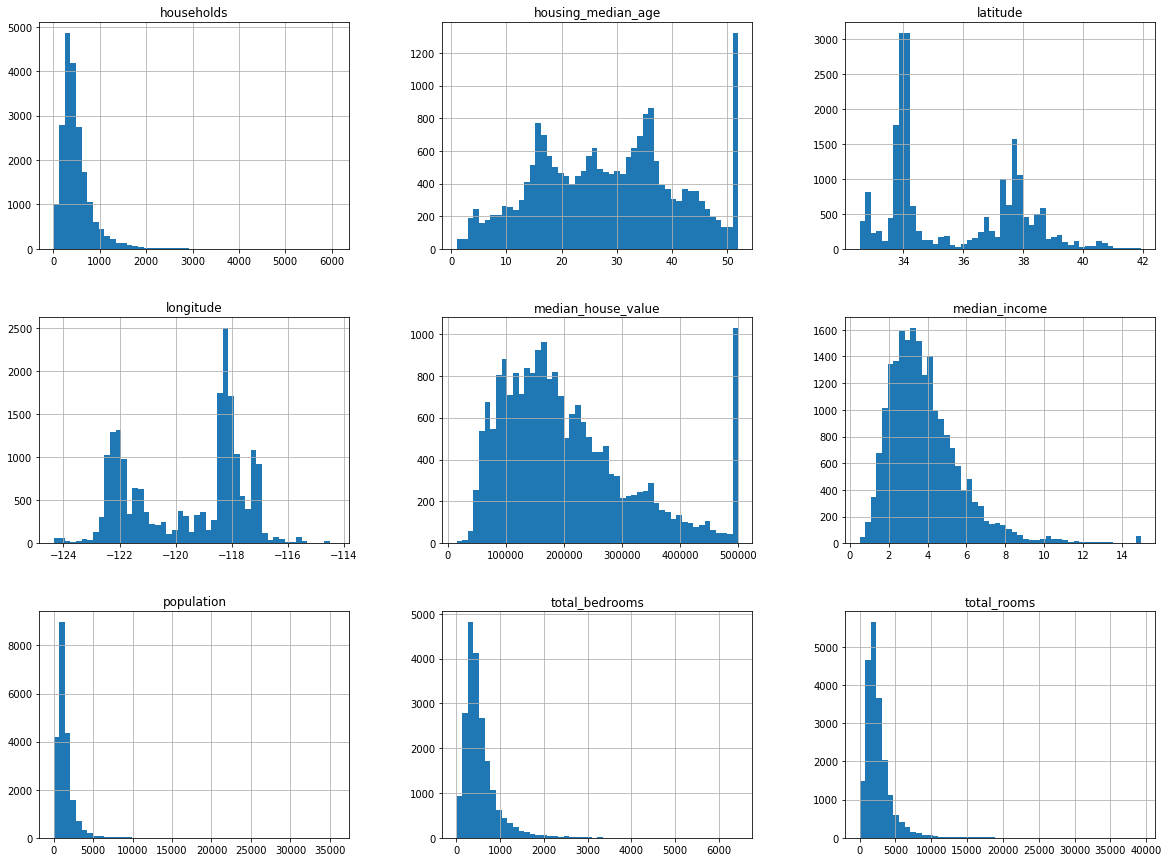

In [12]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

Note that many histograms are right skewed. 

Here we can see that the housing median age and median house value are capped.

**Now, let’s create a pair plot for a quick and succinct examination of our numerical data:**

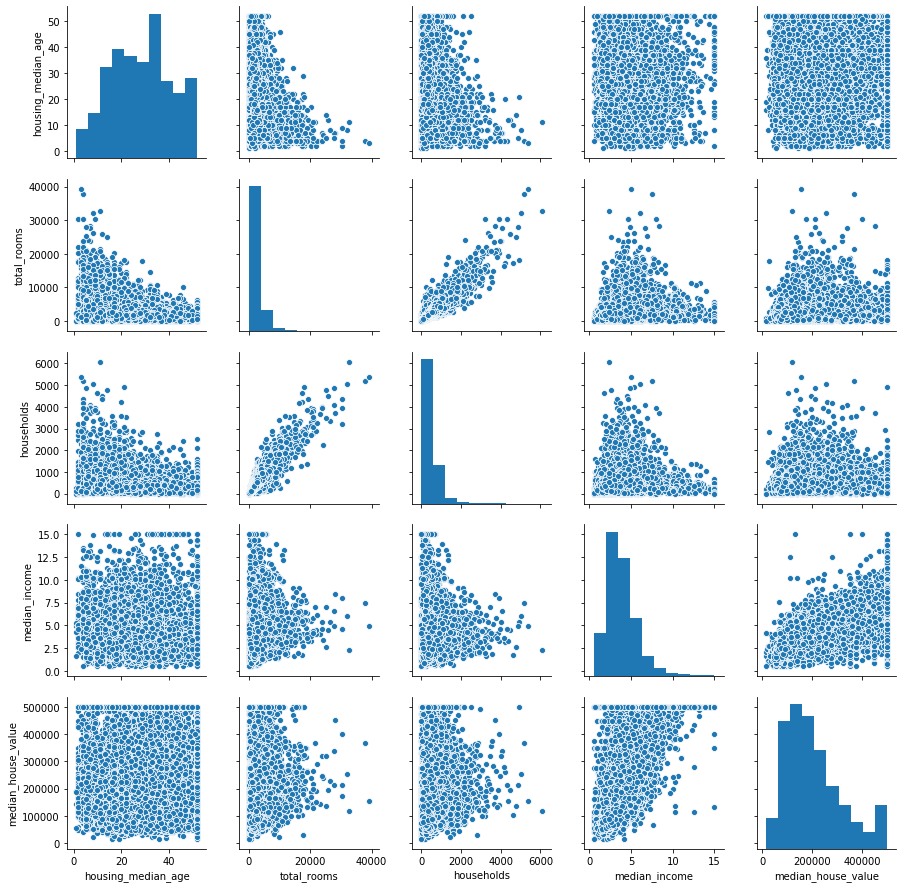

In [13]:
sns.pairplot(housing.drop(['longitude', 'latitude', 'population', 'total_bedrooms'], axis=1))
plt.show()

**A heatmap of correlation may give us an understanding of which variables are important**

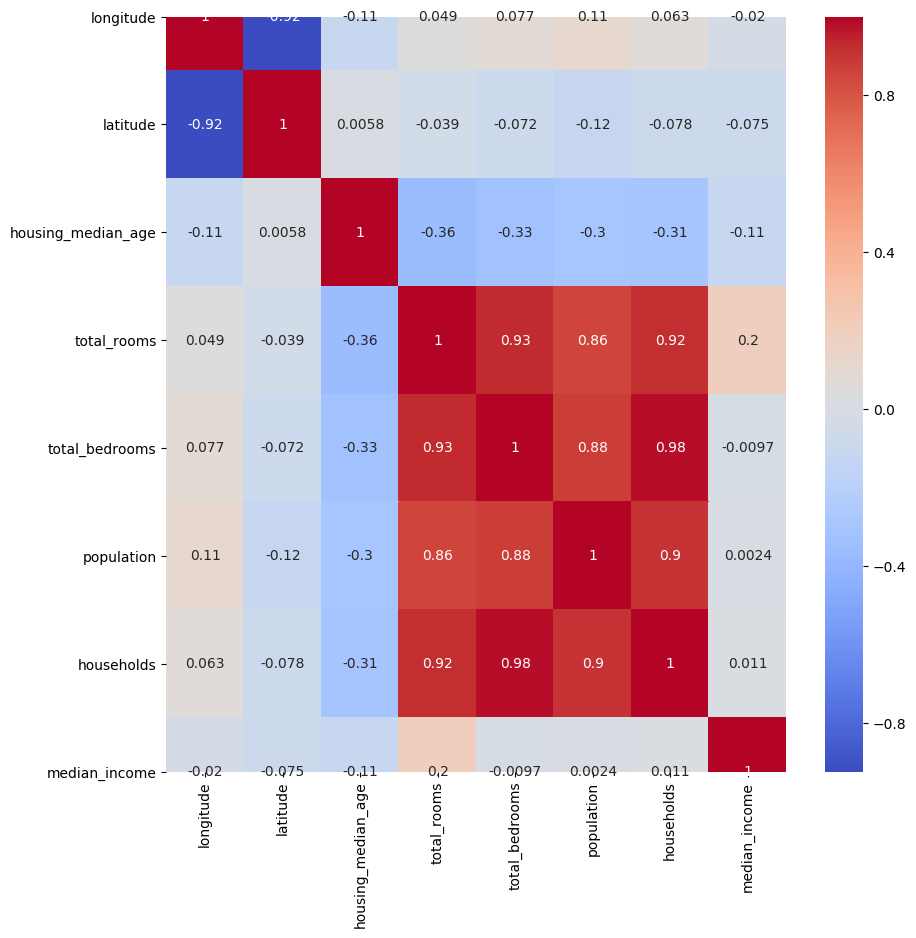

In [166]:
plt.figure(figsize=(10,10), dpi=100)
ax=sns.heatmap(housing.corr(), annot=True, cmap="coolwarm")
ax.set_ylim()
plt.show()

**As expected, there is a high correlation between median income & median house value. Thus, the median income is the most promising feature to predict the median house value.**

### Create a Test Set <a name="createtest"></a>

Before continuing, let’s split our data in a training and test set:

In [15]:
from sklearn.model_selection import train_test_split

**Stratified Sampling based on income**

Here we seek to preserve the proportion of income categories present in the full dataset in the test dataset. The reason being that median income seems to be very important to predict median house prices (see their high correlation in the figure above).

In [16]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

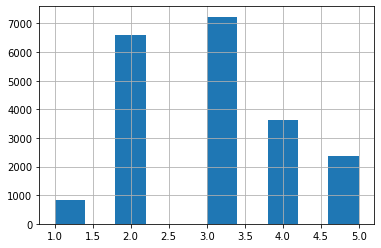

In [17]:
housing["income_cat"].hist()
plt.show()

In [18]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])

In [19]:
dfp_strat = strat_test_set["income_cat"].value_counts() / len(strat_test_set) # Stratified test set proportions
dfp_strat

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

**Random sampling (for comparison)**

In [20]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [21]:
print (train_set.shape , test_set.shape)

(16512, 11) (4128, 11)


In [22]:
dfp_rand = test_set["income_cat"].value_counts() / len(test_set)
dfp_rand

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

In [23]:
dfp_all = housing["income_cat"].value_counts() / len(housing) # Original dataset proportions
dfp_all

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

**Sampling bias comparison of stratified vs. random sampling**

Now, let's compare the income category proportions in the original dataset, the test set generated using random sampling and the test set generated using stratified sampling:

In [24]:
dfp = pd.concat([dfp_all, dfp_rand, dfp_strat], axis=1)
dfp.columns=['Original', 'Random', 'Stratified']
dfp['Random % error'] = (dfp['Original']-dfp['Random'])*100 / dfp['Original']
dfp['Stratified % error'] = (dfp['Original']-dfp['Stratified'])*100 / dfp['Original']
dfp.sort_index()

,Original,Random,Stratified,Random % error,Stratified % error
1,0.039826,0.040213,0.039729,-0.973236,0.243309
2,0.318847,0.324370,0.318798,-1.732260,0.015195
3,0.350581,0.358527,0.350533,-2.266446,0.013820
4,0.176308,0.167393,0.176357,5.056334,-0.027480
5,0.114438,0.109496,0.114583,4.318374,-0.127011


The test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, in contrast to the test set generated using random sampling (lower errors for stratified sampling when compared to random sampling).

In [25]:
for dataset in (strat_train_set, strat_test_set):
    dataset.drop("income_cat", axis=1, inplace=True)

In [26]:
housing = strat_train_set.copy()

### Visualizing Geographical Data <a name="vizgeodata"></a>

**Let’s start by creating a latitude vs longitude scatter plot that highlights high-density areas:**

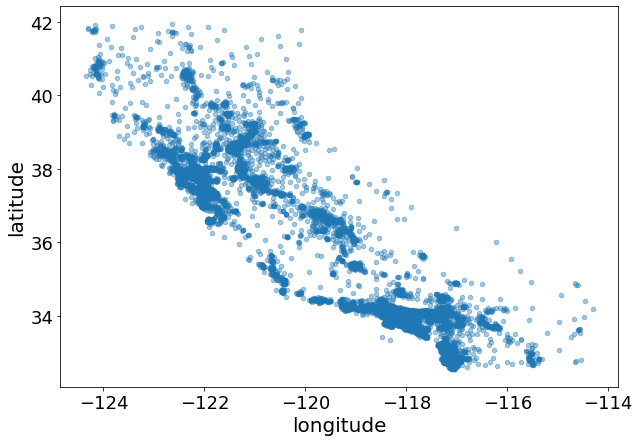

In [27]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(10,7))
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.xticks( fontsize=18)
plt.yticks( fontsize=18)
plt.show()

**Now let’s visualize the price and populations of these blocks:**

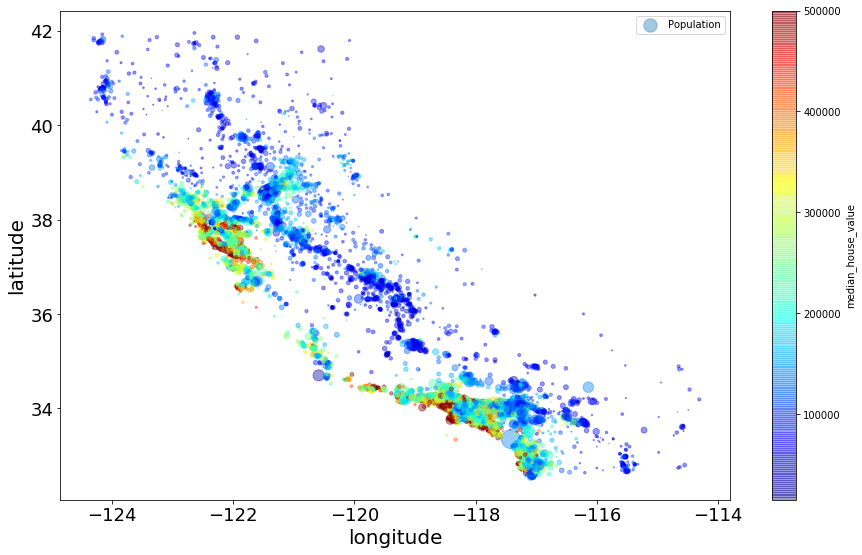

In [28]:
fig, ax = plt.subplots(1,1)
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,9), s=housing.population/100,
            label='Population', c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True, ax=ax
            )
plt.xlabel('longitude', fontsize=20)
plt.ylabel('latitude', fontsize=20)
plt.xticks( fontsize=18)
plt.yticks( fontsize=18)
plt.show()

Each circle represents a block, the larger the circle the more population that block has. Red indicates more expensive houses and blue/purple cheaper ones.

**Housing prices are very related to the location: for example, houses near the ocean tend to have higher prices.**

### Median House Value vs Median Income <a name="hvaluevsincome"></a>

Let’s look in more detail at the scatterplot of these two variables:

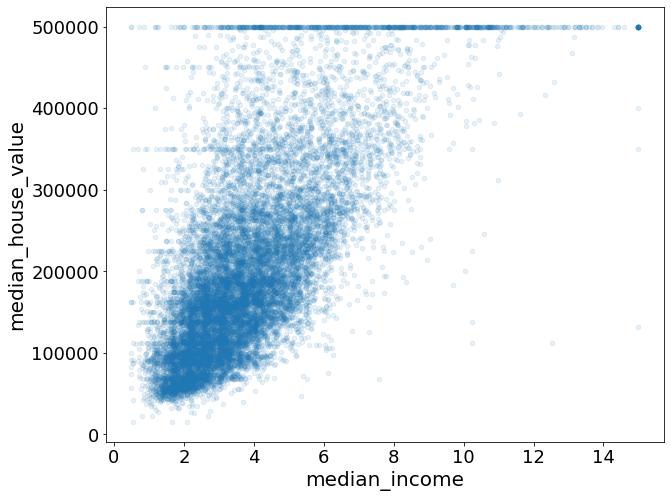

In [29]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', figsize=(10, 8), alpha=0.1)
plt.xlabel('median_income', fontsize=20)
plt.ylabel('median_house_value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

This plot shows a few things: 

* There is indeed a strong correlation between these variables.

* We can also see the price cap at \\$500,000 that we commented earlier.

* Finally, we can see that there are horizontal lines at different median house values: at around \\$450,000, around \\$350,000, \\$280,000 and some more below that. These are quirks that we may want to remove, otherwise our machine learning algorithm may reproduce them. 


### Create new Features <a name="newfeatures"></a>

So far, we have visualized and studied the relation between the median house value and the total number of rooms, total number of beedrooms and total population per block. 

But obviously, we expect that these absolute values are not going to be very useful for our analysis and not going to be very correlated to our response variable, more meaningful features would be the values of these original features **per household** for example.

So, for example, we would expect that blocks with a higher number of rooms per household will be more expensive.

We can create these new features and then take a look at their relationship with the response variable.


In [30]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [31]:
housing.corr()['median_house_value']

longitude                  -0.047432
latitude                   -0.142724
housing_median_age          0.114110
total_rooms                 0.135097
total_bedrooms              0.047689
population                 -0.026920
households                  0.064506
median_income               0.687160
median_house_value          1.000000
rooms_per_household         0.146285
bedrooms_per_room          -0.259984
population_per_household   -0.021985
Name: median_house_value, dtype: float64

As we can see the bedrooms_per_room feature is much more correlated with the median house value than the total number of rooms or bedrooms. Houses with a lower bedroom/room ratio tend to be more expensive.

**Let's create another pair plot with these new features:**

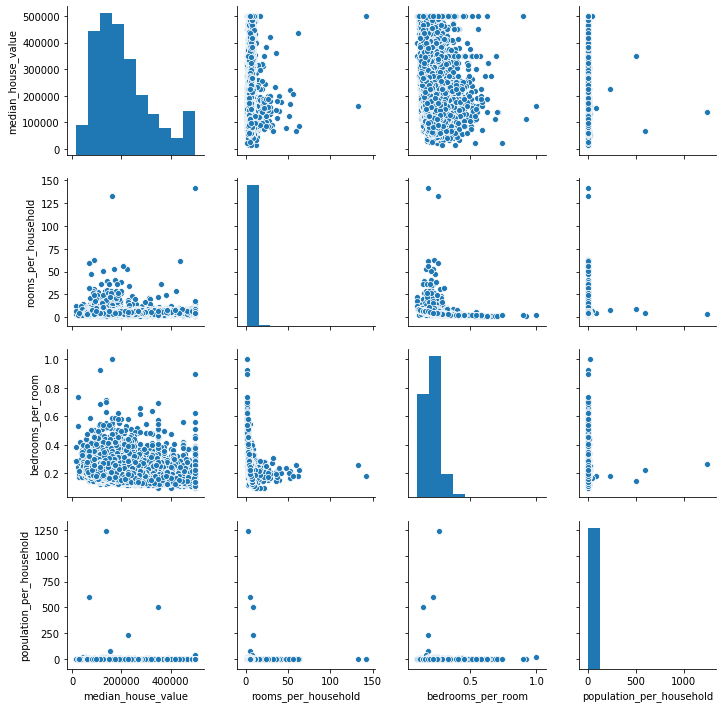

In [32]:
sns.pairplot(housing[['median_house_value','rooms_per_household', 'bedrooms_per_room', 'population_per_household']])
plt.show()

We can see there are records with a high value of population_per_household (40+), let's create a new pair plot without those records. Now the plot is much clearer:

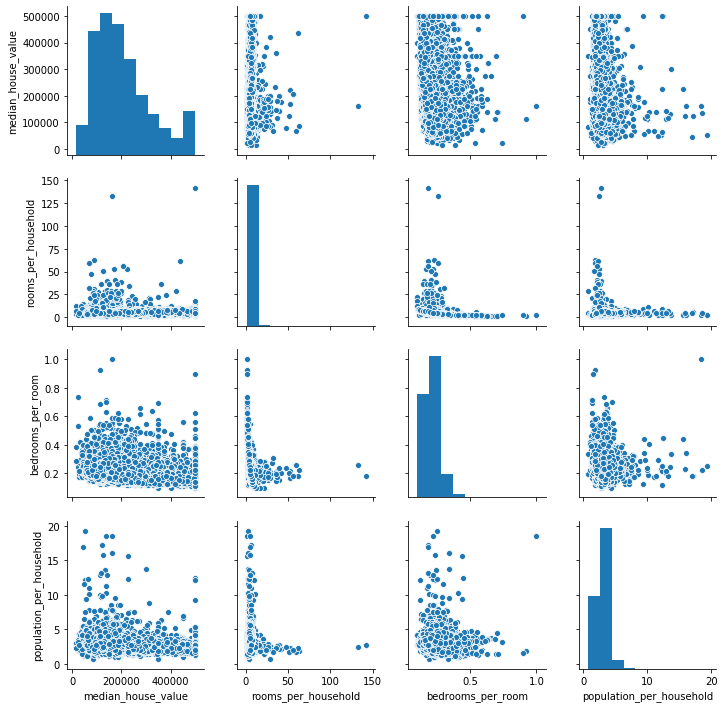

In [33]:
sns.pairplot(housing[['median_house_value','rooms_per_household', 'bedrooms_per_room', 'population_per_household']][housing['population_per_household']<40])
plt.show()

Finally, let’s look at the correlations again:

In [34]:
housing[housing['population_per_household']<40].corr()['median_house_value']

longitude                  -0.047552
latitude                   -0.142503
housing_median_age          0.113827
total_rooms                 0.135282
total_bedrooms              0.047839
population                 -0.026820
households                  0.064672
median_income               0.687540
median_house_value          1.000000
rooms_per_household         0.146083
bedrooms_per_room          -0.259841
population_per_household   -0.240109
Name: median_house_value, dtype: float64

By removing the anomalous points, we can see that the (negative) correlation between population_per_household and the median house value is much higher, which makes sense.

In [35]:
housing[housing['population_per_household']>40] # the six anomalous records

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
9172,-118.59,34.47,5.0,538.0,98.0,8733.0,105.0,4.2391,154600.0,INLAND,5.123810,0.182156,83.171429
16669,-120.70,35.32,46.0,118.0,17.0,6532.0,13.0,4.2639,350000.0,NEAR OCEAN,9.076923,0.144068,502.461538
13034,-121.15,38.69,52.0,240.0,44.0,6675.0,29.0,6.1359,225000.0,INLAND,8.275862,0.183333,230.172414
3364,-120.51,40.41,36.0,36.0,8.0,4198.0,7.0,5.5179,67500.0,INLAND,5.142857,0.222222,599.714286
8874,-118.45,34.06,52.0,204.0,34.0,1154.0,28.0,9.3370,500001.0,<1H OCEAN,7.285714,0.166667,41.214286
19006,-121.98,38.32,45.0,19.0,5.0,7460.0,6.0,10.2264,137500.0,INLAND,3.166667,0.263158,1243.333333


### Ocean Proximity <a name="oceanprox"></a>

To end the EDA, let's take a look at the ocean_proximity variable. Let's start by creating a count plot:

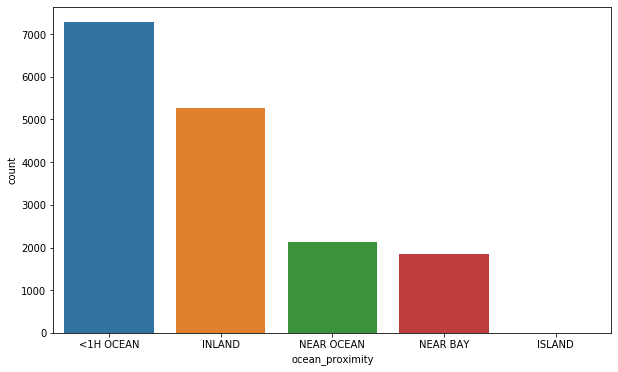

In [36]:
plt.figure(figsize=(10,6))
ax = sns.countplot(housing['ocean_proximity'], order = housing['ocean_proximity'].value_counts().index )

In [37]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

**Let's see the mean median house value per ocean proximity category:**

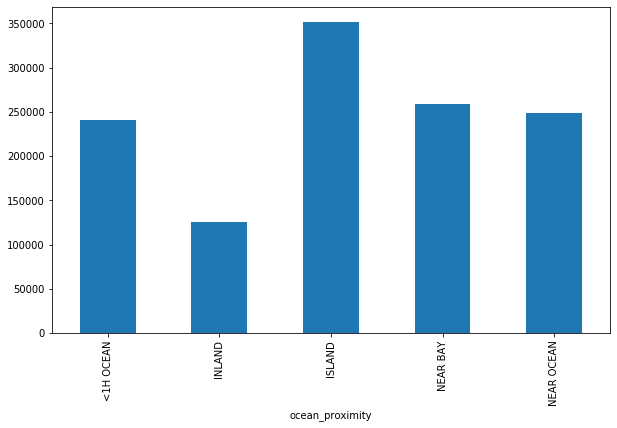

In [38]:
plt.figure(figsize=(10,6))
housing.groupby(by='ocean_proximity').mean()['median_house_value'].plot(kind='bar')
plt.show()

In [39]:
housing.groupby(by='ocean_proximity').mean()['median_house_value']

ocean_proximity
<1H OCEAN     240820.716465
INLAND        125310.872316
ISLAND        351100.000000
NEAR BAY      258740.476448
NEAR OCEAN    248359.495763
Name: median_house_value, dtype: float64

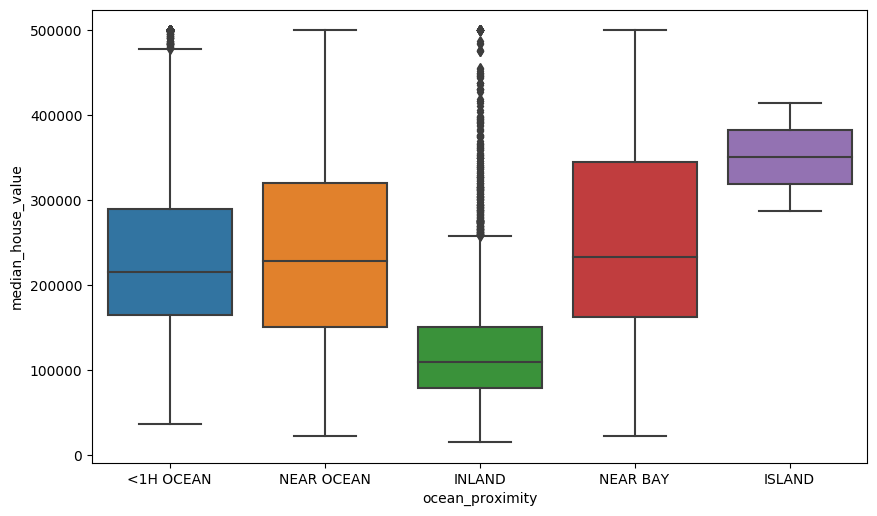

In [40]:
plt.figure(figsize=(10,6), dpi=100)
sns.boxplot(x=housing['ocean_proximity'], y=housing['median_house_value'])
plt.show()

**As we commented before, houses near the ocean tend to have higher prices.**

## 6. Data Preparation <a name="dpw"></a>

In [41]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [42]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [43]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


### Dealing with missing values  <a name="missingval"></a>

**As we saw before, the total_bedrooms feature has missing values, one easy way of visualizing this is with a heatmap:**

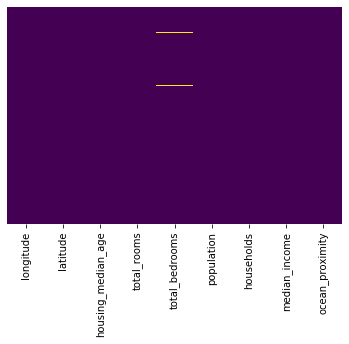

In [44]:
sns.heatmap(housing.isnull(), yticklabels=False, cbar = False, cmap="viridis")
plt.show()

In [45]:
perc_null = housing['total_bedrooms'].isna().sum()*100/housing['total_rooms'].count()
perc_null # Aprox. 1% of the data is missing

0.9568798449612403

Some of the options we have to deal with the missing values are:
1. Remove entries with missing values
2. Get rid of the entire feature
3. Use some form of imputation (constant, mean, median, etc.) 

There are more advanced methods we could try (for example calculating the median based on the ocean_proximity feature), but let's start with these for now.

In [46]:
# housing.dropna(subset=['total_bedrooms'])
# housing.drop('total_bedrooms', axis=1)
median_bedr = housing['total_bedrooms'].median()
# housing['total_bedrooms'].fillna(value=median_bedr)

In [47]:
median_bedr

433.0

**Let's use the median as our imputing strategy**

In [48]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [49]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [50]:
imputer.fit(housing_num) # the imputer has computed the median of each feature

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [52]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [53]:
X = imputer.transform(housing_num)

In [54]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [55]:
housing_tr.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 8 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16512 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


### Converting Categorical Features  <a name="dummy"></a>

**We need to convert categorical features to dummy variables. Otherwise our machine learning algorithms won't be able to directly take in those features as inputs.**

In [56]:
housing_cat = housing[['ocean_proximity']]

In [57]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(drop='first')
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x4 sparse matrix of type '<class 'numpy.float64'>'
	with 9236 stored elements in Compressed Sparse Row format>

In [58]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Feature Engineering <a name="feateng"></a>

Let's create the combined features we discussed earlier:

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

In [60]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [61]:
class CombinedFeaturesAdder(BaseEstimator, TransformerMixin): # Custom class
    
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self # Nothing else to do
    
    def transform(self, X, y=None):
        
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [62]:
feature_adder = CombinedFeaturesAdder(add_bedrooms_per_room=False)

In [63]:
housing_extra_features = feature_adder.transform(housing.values)

In [64]:
housing_extra_features

array([[-121.89, 37.29, 38.0, ..., '<1H OCEAN', 4.625368731563422,
        2.094395280235988],
       [-121.93, 37.05, 14.0, ..., '<1H OCEAN', 6.008849557522124,
        2.7079646017699117],
       [-117.2, 32.77, 31.0, ..., 'NEAR OCEAN', 4.225108225108225,
        2.0259740259740258],
       ...,
       [-116.4, 34.09, 9.0, ..., 'INLAND', 6.34640522875817,
        2.742483660130719],
       [-118.01, 33.82, 31.0, ..., '<1H OCEAN', 5.50561797752809,
        3.808988764044944],
       [-122.45, 37.77, 52.0, ..., 'NEAR BAY', 4.843505477308295,
        1.9859154929577465]], dtype=object)

### Feature Scaling <a name="featscl"></a>

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
scaler = StandardScaler()

In [67]:
housing_scaled = scaler.fit_transform(housing_num)

In [68]:
housing_scaled[1,:]

array([-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.03462064,
       -0.99833135, -1.02222705,  1.33645936])

### Transformation Pipelines <a name="transfPip"></a>

In [69]:
from sklearn.pipeline import Pipeline

In [70]:
estimators = [('imputer', SimpleImputer(strategy="median")), ('add_features', CombinedFeaturesAdder()), 
             ('scale_features', StandardScaler())]

In [71]:
num_pipe = Pipeline(estimators)

In [72]:
num_pipe

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('add_features',
                 CombinedFeaturesAdder(add_bedrooms_per_room=True)),
                ('scale_features',
                 StandardScaler(copy=True, with_mean=True, with_std=True))],
         verbose=False)

In [73]:
from sklearn.compose import ColumnTransformer

In [74]:
num_features = list(housing_num)
cat_features = ["ocean_proximity"]

In [75]:
full_pipeline = ColumnTransformer([
    ("num", num_pipe, num_features),
    ("cat", OneHotEncoder(), cat_features)
])

**Remove anomalies**

We need to remove the rows corresponding to the anomalous values in housing_labels:

In [76]:
housing_labels = housing_labels.drop(list(housing[housing["population"]/housing["households"] > 40].index))

**Transform data**

In [77]:
housing_prepared = full_pipeline.fit_transform(housing[housing["population"]/housing["households"] < 40])

## 7. Model Selection & Training <a name="mfit"></a>

### Linear Regression <a name="linearreg"></a>

In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [80]:
lin_reg.coef_ # linear regression coefficients

array([-57258.63562371, -59358.71927954,  13196.52423974,  -3567.73400186,
         7412.4818501 , -21973.61881927,  23263.7469628 ,  74254.24479631,
         6129.04470161, -15270.92794977,   9479.02330312, -15517.80638905,
       -52425.16422393, 104414.81508661, -21584.34585646, -14887.49861717])

In [81]:
lin_reg.intercept_

234839.39651429374

**Let's try out this model on some data:**

In [82]:
inspect_data = housing.iloc[:10]
inspect_labels = housing_labels[:10]

In [83]:
inspect_data_prepared = full_pipeline.transform(inspect_data)
inspect_data_predictions = lin_reg.predict(inspect_data_prepared)

In [84]:
list(inspect_data_predictions)

[220771.79966035744,
 322541.1739219642,
 219041.43284144034,
 48489.35097625514,
 194607.07096678298,
 156914.49410299468,
 427768.21601514576,
 233155.1975796764,
 130452.72736391064,
 -87966.62264408998]

In [85]:
list(inspect_labels.values)

[286600.0,
 340600.0,
 196900.0,
 46300.0,
 254500.0,
 127900.0,
 500001.0,
 140200.0,
 95000.0,
 500001.0]

In [86]:
np.mean(abs(inspect_data_predictions-inspect_labels.values)*100/inspect_labels.values)

32.612355826495275

This model is not very accurate, we get a mean prediction error of aprox. 33%.

**Model Evaluation**

Let's calculate the RMSE on the training set:

In [87]:
from sklearn.metrics import mean_squared_error

In [88]:
lin_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, lin_reg.predict(housing_prepared))))
lin_rmse_training

67679.40140229349


Let's use cross-validation for a better evaluation of our model:

In [89]:
from sklearn.model_selection import cross_val_score

In [90]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
lin_rmse_scores = np.sqrt(-lin_scores)

In [91]:
display_scores(lin_rmse_scores)

Scores: [66423.49172832 66871.00311683 69554.94489818 71237.25875004
 66812.83647605 70467.5429266  64457.9504553  66944.3340712
 69996.8110445  67162.74773472]
Mean: 67992.892120174
Standard deviation: 2061.652771083683


Given that most median_housing_values range between \\$120,000 and \\$265,000, an RMSE on the training data of almost \\$70,000 is not very satisfying and it's indicative of underfitting.

**Learning Curves**

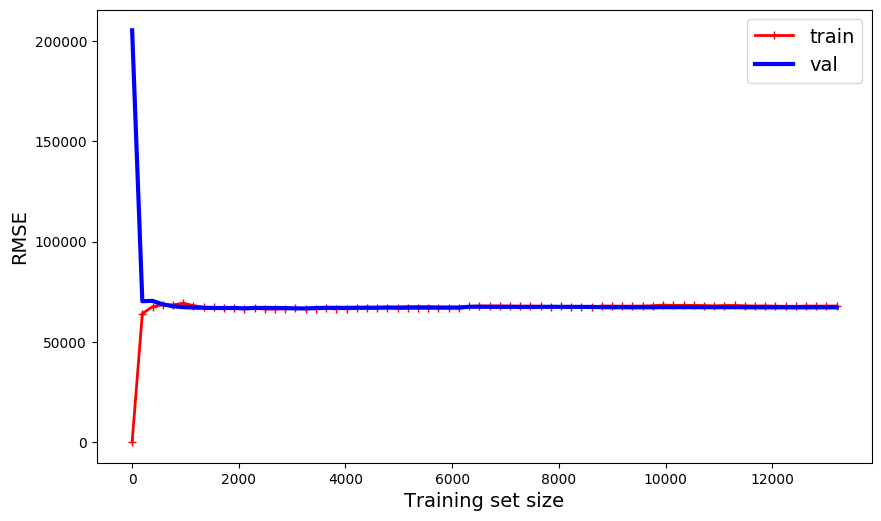

In [92]:
learning_curves(lin_reg, housing_prepared, housing_labels)

In the figure above, we can see that the training and validation curves converge, fitting the model on 8,000 observations or more yields practically the same training and validation error; also as we saw before, the error is quite high, this means that our model has high bias.

Possible solutions to underfitting are: selecting a more powerful model, adding better features or reduce the constraints on the model. As we are not using regularization, we can rule out the last option.

Let's start by trying a more complex model.

### Decision Tree <a name="destree"></a>

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

**Model Evaluation**

In [95]:
tree_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, tree_reg.predict(housing_prepared))))
tree_rmse_training

0.0


An error of 0% on the training data probably means that the decision tree is severely overfitting the data.

In [96]:
tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
tree_rmse_scores = np.sqrt(-tree_scores)

In [97]:
display_scores(tree_rmse_scores)

Scores: [68872.95270253 66613.17217436 70763.98179326 69355.23455415
 70629.49535751 75596.60977596 69645.92397071 70305.37718767
 75106.52626396 68700.44508376]
Mean: 70558.97188638843
Standard deviation: 2651.756346455922


**As we can see, the performance of the Decision Tree is worse than the performance of the Linear Regression model.**

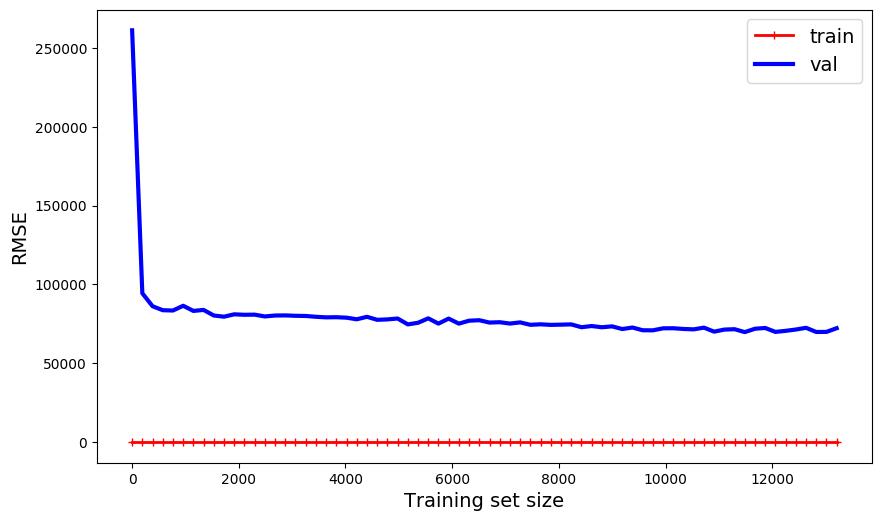

In [98]:
learning_curves(tree_reg, housing_prepared, housing_labels)

In this case we have a low bias and high variance model.

### Random Forest <a name="rforest"></a>

In [99]:
from sklearn.ensemble import RandomForestRegressor

In [100]:
forest_reg = RandomForestRegressor(n_jobs=4)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

**Model Evaluation**

In [101]:
forest_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, forest_reg.predict(housing_prepared))))
forest_rmse_training

22647.618273692104


In [102]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
forest_rmse_scores = np.sqrt(-forest_scores)

In [103]:
display_scores(forest_rmse_scores)

Scores: [51289.36064379 50780.08334224 52219.18015521 53586.38571179
 51565.26299446 55408.16414161 51904.31672463 51410.89417906
 56103.98775657 53330.37979867]
Mean: 52759.80154480453
Standard deviation: 1719.252354688373


As expected, random forest is the best out of the three models tried so far. However, the error is much lower in the training set than in the validation sets, thus, the model is overfitting the training set.

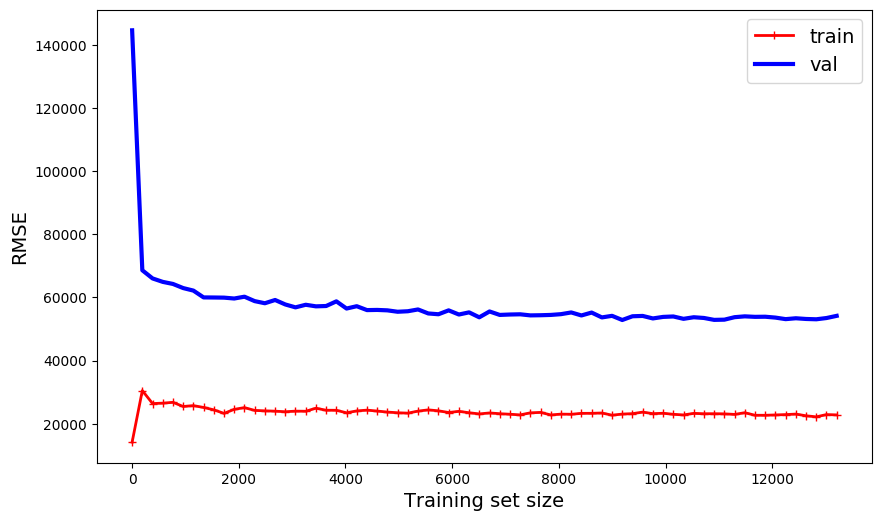

In [104]:
learning_curves(forest_reg, housing_prepared, housing_labels)

This model overfits the training data, it has low bias and high variance.

### K-nearest neighbors <a name="knnreg"></a>

In [105]:
from sklearn.neighbors import KNeighborsRegressor

In [106]:
knn_reg = KNeighborsRegressor()
knn_reg.fit(housing_prepared, housing_labels)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

**Model Evaluation**

In [107]:
knn_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, knn_reg.predict(housing_prepared))))
knn_rmse_training

47841.008787288


In [108]:
knn_scores = cross_val_score(knn_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
knn_rmse_scores = np.sqrt(-knn_scores)

In [109]:
display_scores(knn_rmse_scores)

Scores: [57764.2060889  59312.61207944 59167.50491445 60226.73150953
 59166.86944976 62186.54350582 58397.11617613 57276.2520666
 60896.67136547 58382.63461915]
Mean: 59277.7141775246
Standard deviation: 1410.0273899678382


### Support Vector Machines: Linear Kernel <a name="svml_model"></a>

In [110]:
from sklearn.svm import SVR

In [111]:
svml_reg = SVR(kernel='linear')
svml_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

**Model Evaluation**

In [112]:
svml_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, svml_reg.predict(housing_prepared))))
svml_rmse_training

110224.49963734817


In [113]:
svml_scores = cross_val_score(svml_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=4)
svml_rmse_scores = np.sqrt(-svml_scores)

In [114]:
display_scores(svml_rmse_scores)

Scores: [104720.6993623  111646.98401906 109231.22038075 112690.25330569
 109594.84284001 114942.40420709 110008.88025932 113357.62294478
 112974.55496865 110685.3899291 ]
Mean: 110985.28522167564
Standard deviation: 2718.21900954951


### Support Vector Machines: Polynomial Kernel <a name="svmp_model"></a>

In [115]:
svmp_reg = SVR(kernel='poly')
svmp_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='poly', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

**Model Evaluation**

In [116]:
svmp_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, svmp_reg.predict(housing_prepared))))
svmp_rmse_training

118660.93049919214


In [117]:
svmp_scores = cross_val_score(svmp_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
svmp_rmse_scores = np.sqrt(-svmp_scores)

In [118]:
display_scores(svmp_rmse_scores)

Scores: [111550.2279737  119752.73995754 117061.19190125 120631.30140877
 117654.75155775 122596.72018687 117878.65496298 121433.25612842
 120526.57970594 118141.12939184]
Mean: 118722.65531750696
Standard deviation: 2944.638941556358


### Support Vector Machines: Gaussian Kernel <a name="svmr_model"></a>

In [119]:
svmr_reg = SVR(kernel='rbf')
svmr_reg.fit(housing_prepared, housing_labels)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

**Model Evaluation**

In [120]:
svmr_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, svmr_reg.predict(housing_prepared))))
svmr_rmse_training

118526.60674188101


In [121]:
svmr_scores = cross_val_score(svmr_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=4)
svmr_rmse_scores = np.sqrt(-svmr_scores)

In [122]:
display_scores(svmr_rmse_scores)

Scores: [111407.672139   119501.2785418  116800.05105802 120526.45064157
 117335.51031483 122391.18331347 117693.3204917  121287.2307965
 120362.89320552 118021.09651721]
Mean: 118532.66870196236
Standard deviation: 2947.978632256354


SVMs with default hyperparameters don't yield good results for this problem

### XGBoost <a name="xgb_model"></a>

In [123]:
from xgboost import XGBRegressor

In [124]:
xgb_reg = XGBRegressor(verbosity=0, n_jobs=4)
xgb_reg.fit(housing_prepared, housing_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

**Model Evaluation**

In [125]:
xgb_rmse_training = print(np.sqrt(mean_squared_error(housing_labels, xgb_reg.predict(housing_prepared))))
xgb_rmse_training

50738.28514169324


In [126]:
xgb_scores = cross_val_score(xgb_reg, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error', n_jobs=4)
xgb_rmse_scores = np.sqrt(-xgb_scores)

In [127]:
display_scores(xgb_rmse_scores)

Scores: [52302.59767023 49914.64172476 52613.22136618 55128.69803454
 53190.48938348 56197.77340023 50817.14580145 50733.41578054
 56665.1088625  53644.45129259]
Mean: 53120.75433165039
Standard deviation: 2203.4877010508103


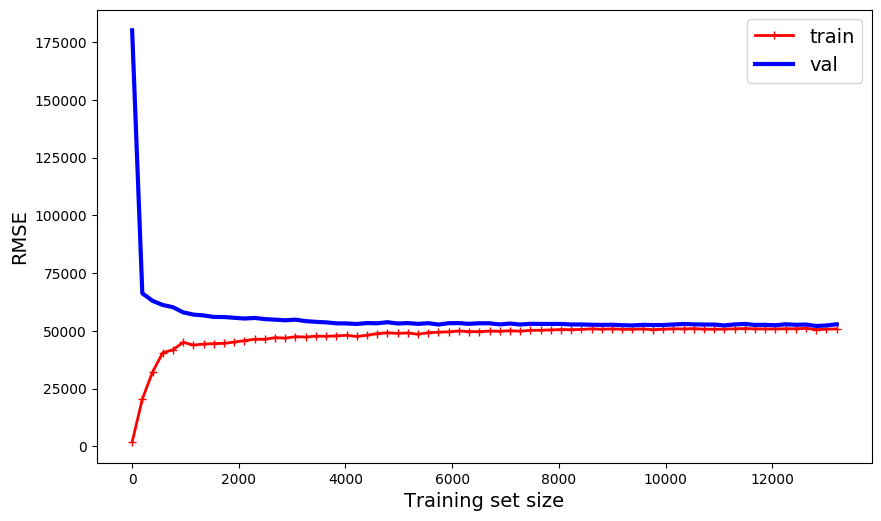

In [128]:
learning_curves(xgb_reg, housing_prepared, housing_labels)

The performance of XGBoost is a little worse than that of Random Forest. But note that for XGBoost the difference between the training and Cross-Validation RMSE is just of 5%.

## 8. Fine-Tune Model <a name="mtuning"></a>

The models that yield the best results are random forest and XGBoost, let's now spend some time tweaking their hyperparameters to improve their performance

### Random Forest <a name="rftuning"></a>

**Let's perform a grid search to find the best combination of hyperparameters**

In [129]:
from sklearn.model_selection import GridSearchCV

In [131]:
forest_reg_gscv = GridSearchCV(RandomForestRegressor(), parameters_forest, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)

In [132]:
forest_reg_gscv.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 11.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [True, False],
   

In [133]:
forest_reg_gscv.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [134]:
forest_reg_gscv.best_estimator_

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [135]:
forest_cvres = forest_reg_gscv.cv_results_

In [136]:
for mean_score, params in zip(forest_cvres["mean_test_score"], forest_cvres["params"]):
    print(np.sqrt(-mean_score), params)

67672.0148410536 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
67357.30146323066 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
67450.93459109603 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
67149.158531962 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
68039.16916933919 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
67269.39866627392 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
66996.93240424866 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2}
66752.28726525047 {'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}
6

**Second Iteration**

In [168]:
forest_reg_gscv2 = GridSearchCV(RandomForestRegressor(), parameters_forest2, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=1)

In [169]:
forest_reg_gscv2.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   24.4s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'bootstrap': [False], 'max_dept

In [170]:
forest_reg_gscv2.best_params_

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [171]:
print(np.sqrt(mean_squared_error(housing_labels, forest_reg_gscv2.predict(housing_prepared))))

18989.17785865537


In [172]:
forest_cvres2 = forest_reg_gscv2.cv_results_

In [173]:
for mean_score, params in zip(forest_cvres2["mean_test_score"], forest_cvres2["params"]):
    print(np.sqrt(-mean_score), params)

50993.1674526921 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 8}
50638.10646606053 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
51033.24503910133 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 12}
51519.577373659646 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 8}
51098.28638883784 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
51115.58168888661 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 12}
51318.49533017872 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8}
51077.68339552604 {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_sample

**Increase n_estimators**

Finally let's pick the parameters that yield the best results and increase the n_estimators parameter:

In [177]:
forest_reg_final = RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=4)

In [178]:
forest_reg_final.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [179]:
print(np.sqrt(mean_squared_error(housing_labels, forest_reg_final.predict(housing_prepared))))

17058.07362525407


In [180]:
forest_final_scores = cross_val_score(forest_reg_final, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
forest_final_rmse_scores2 = np.sqrt(-forest_final_scores)

In [181]:
display_scores(forest_final_rmse_scores2)

Scores: [47497.02948822 46043.8355748  48447.13150957 50044.68317973
 48010.95628561 51692.9014571  46902.90377016 47006.17478631
 51005.48179327 48168.88927735]
Mean: 48481.9987122118
Standard deviation: 1761.459088463649


As we can see, we obtain the best solution by selecting the following hyperparameters:

* **bootstrap: False**
* **max_depth: None**
* **max_features: 'sqrt'**
* **min_samples_leaf: 1**
* **min_samples_split: 10**

In [182]:
perc_diff_rf = (forest_rmse_scores.mean() - forest_final_rmse_scores2.mean())*100 / forest_rmse_scores.mean()
"The RMSE score for this combination of hyperparameters is {:.0f}, which is {:.1f}% lower than the score we got earlier using the default hyperparameter values (which was {:.0f})".format(forest_final_rmse_scores2.mean(), perc_diff_rf,forest_rmse_scores.mean())

'The RMSE score for this combination of hyperparameters is 48482, which is 8.1% lower than the score we got earlier using the default hyperparameter values (which was 52760)'

___

### XGBoost <a name="xgbtuning"></a>

**Let's perform a randomized grid search to find the best combination of hyperparameters**

In [150]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [151]:
parameters_xgboost = {'min_child_weight': randint(low=1, high=10), 
                    'gamma': [0, 0.5, 1, 1.5, 2, 5],
                    'subsample': [0.6, 0.8, 1],
                    'colsample_by_tree': [0.6, 0.8, 1],
                    'max_depth': randint(low=3, high=20)
                    }

In [152]:
xgb_reg_gscv = RandomizedSearchCV(XGBRegressor(verbosity=0), parameters_xgboost, n_jobs=-1, n_iter=100, scoring='neg_mean_squared_error', cv=5, return_train_score=True, verbose=0)

In [154]:
xgb_reg_gscv.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                   param_distributions={'colsample_by_tree': [0.6, 0.8, 1],
                                        'gamma': [0, 0.5, 1, 1.5, 2, 5],
                                        

In [155]:
xgb_reg_gscv.best_params_

{'colsample_by_tree': 0.8,
 'gamma': 1.5,
 'max_depth': 8,
 'min_child_weight': 8,
 'subsample': 1}

In [156]:
xgb_reg_gscv.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_by_tree=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=1.5, importance_type='gain', learning_rate=0.1,
             max_delta_step=0, max_depth=8, min_child_weight=8, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=0)

In [157]:
xgb_cvres = xgb_reg_gscv.cv_results_

In [158]:
for mean_score, params in zip(xgb_cvres["mean_test_score"], xgb_cvres["params"]):
    print(np.sqrt(-mean_score), params)

46963.90369100206 {'colsample_by_tree': 1, 'gamma': 5, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.8}
47791.539277275195 {'colsample_by_tree': 1, 'gamma': 1.5, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.8}
49167.373024706656 {'colsample_by_tree': 0.8, 'gamma': 1.5, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 1}
47695.862211169595 {'colsample_by_tree': 0.6, 'gamma': 5, 'max_depth': 17, 'min_child_weight': 5, 'subsample': 0.6}
48223.16263768332 {'colsample_by_tree': 0.6, 'gamma': 0, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 1}
48480.19886034572 {'colsample_by_tree': 0.6, 'gamma': 1.5, 'max_depth': 19, 'min_child_weight': 5, 'subsample': 1}
51188.13203318778 {'colsample_by_tree': 0.6, 'gamma': 0, 'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6}
48459.112954117714 {'colsample_by_tree': 0.6, 'gamma': 2, 'max_depth': 17, 'min_child_weight': 2, 'subsample': 0.8}
47939.56648979367 {'colsample_by_tree': 0.6, 'gamma': 1.5, 'max_depth': 7, 'min_c

**Increase n_estimators**

In [183]:
xgb_reg_final = XGBRegressor(colsample_bytree=0.8, gamma=1.5, max_depth=8, min_child_weight=8, subsample=1, n_estimators=500, n_jobs=-1, verbosity=0)

In [184]:
xgb_reg_final.fit(housing_prepared, housing_labels)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=8, missing=None, n_estimators=500,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)

In [185]:
print(np.sqrt(mean_squared_error(housing_labels, xgb_reg_final.predict(housing_prepared))))

15088.578485437703


In [186]:
xgb_final_scores = cross_val_score(xgb_reg_final, housing_prepared, housing_labels, cv=10, scoring='neg_mean_squared_error')
xgb_final_rmse_scores = np.sqrt(-xgb_final_scores)

In [187]:
display_scores(xgb_final_rmse_scores)

Scores: [45052.28144483 42761.38510745 43969.11264656 46382.22377393
 44306.59127632 48722.74674228 43723.51028628 44569.66546351
 47009.64924208 44146.26790488]
Mean: 45064.34338881305
Standard deviation: 1699.0533217255681


**As we can see, we obtain the best solution by selecting the following hyperparameters:**

* **colsample_bytree: 0.8**
* **gamma: 1.5**
* **max_depth: 8**
* **min_child_weight: 8**
* **subsample: 1**

In [188]:
perc_diff_xgb = (xgb_rmse_scores.mean() - xgb_final_rmse_scores.mean())*100 / xgb_rmse_scores.mean()
"The RMSE score for this combination of hyperparameters is {:.0f}, which is {:.1f}% lower than the score we got earlier using the default hyperparameter values (which was {:.0f})".format(xgb_final_rmse_scores.mean(), perc_diff_xgb,xgb_rmse_scores.mean())

'The RMSE score for this combination of hyperparameters is 45064, which is 15.2% lower than the score we got earlier using the default hyperparameter values (which was 53121)'

**MAPE**

In [189]:
mean_absolute_percentage_error(housing_labels, xgb_reg_final.predict(housing_prepared))

5.955889558472219

In [190]:
symmetric_mean_absolute_percentage_error(housing_labels, xgb_reg_final.predict(housing_prepared))

5.8064948579715

## 9. Model Evaluation on Test Set <a name="testeval"></a>

Finally let's evaluate our final model on the test set, we select "xgb_reg_final" as our final model because it's the one with the best performance (lowest mean cross validation rmse):

In [191]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [192]:
y_test = y_test.drop(list(X_test[X_test["population"]/X_test["households"] > 40].index))

In [193]:
X_test_prepared = full_pipeline.transform(X_test[X_test["population"]/X_test["households"] < 40])

In [194]:
final_predictions = xgb_reg_final.predict(X_test_prepared)

In [195]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [196]:
final_rmse # RMSE on the test set

43231.01060536413

**MAPE & SMAPE**

In [197]:
mean_absolute_percentage_error(y_test, final_predictions)

15.904098034843337

In [198]:
symmetric_mean_absolute_percentage_error(y_test, final_predictions)

14.455995135117492

**RMSE Confidence Interval (95%)**

We can compute a 95% confidence interval for the test RMSE using t-scores:

In [199]:
from scipy import stats

In [200]:
confidence = 0.95

In [201]:
squared_errors = (final_predictions - y_test)**2

In [202]:
np.sqrt(stats.t.interval(confidence, len(squared_errors)-1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))

array([41293.38138868, 45085.44343146])